In [5]:
import os, math, copy, time, json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from typing import Dict, Tuple, List

import numpy as np
import matplotlib.pyplot as plt

# sklearn for KMeans
try:
    from sklearn.cluster import KMeans
    _SKLEARN_OK = True
except Exception as e:
    print("scikit-learn not available")
    _SKLEARN_OK = False

SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

FAST_TRAIN_EPOCHS = 2
BATCH_SIZE        = 128

Device: cuda


In [6]:
# MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=512,      shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_ds), "| Test size:", len(test_ds))

Train size: 60000 | Test size: 10000


In [7]:
class FCNN(nn.Module):
    def __init__(self, in_dim=28*28, hidden=(512, 256), num_classes=10):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU(inplace=True)]
            last = h
        layers += [nn.Linear(last, num_classes)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def get_models():
    return FCNN().to(device), SimpleCNN().to(device)

fcnn, cnn = get_models()
sum_params_fcnn = sum(p.numel() for p in fcnn.parameters())
sum_params_cnn  = sum(p.numel() for p in cnn.parameters())
print(f"FCNN params: {sum_params_fcnn:,} | CNN params: {sum_params_cnn:,}")

FCNN params: 535,818 | CNN params: 1,701,130


In [8]:
def train_one_epoch(model, loader, opt, criterion):
    model.train()
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()

def evaluate(model, loader):
    model.eval()
    correct = 0
    tot = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            logits = model(x)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            tot += y.size(0)
    return 100.0 * correct / tot

def baseline_train_or_load(fcnn, cnn, epochs=2):
      print(f"Training FCNN for {epochs} epoch(s)...")
      opt = torch.optim.Adam(fcnn.parameters(), lr=1e-3)
      criterion = nn.CrossEntropyLoss()
      for ep in range(epochs):
          train_one_epoch(fcnn, train_loader, opt, criterion)
      torch.save(fcnn.state_dict(), "fcnn_baseline.pt")
      print("Saved:", "fcnn_baseline.pt")

      print(f"Training CNN for {epochs} epoch(s)...")
      opt = torch.optim.Adam(cnn.parameters(), lr=1e-3)
      criterion = nn.CrossEntropyLoss()
      for ep in range(epochs):
          train_one_epoch(cnn, train_loader, opt, criterion)
      torch.save(cnn.state_dict(), "cnn_baseline.pt")
      print("Saved:", "cnn_baseline.pt")

baseline_train_or_load(fcnn, cnn, epochs=2)
base_acc_fcnn = evaluate(fcnn, test_loader)
base_acc_cnn  = evaluate(cnn, test_loader)
print(f"Baseline Acc -> FCNN: {base_acc_fcnn:.2f}% | CNN: {base_acc_cnn:.2f}%")

Training FCNN for 2 epoch(s)...
Saved: fcnn_baseline.pt
Training CNN for 2 epoch(s)...
Saved: cnn_baseline.pt
Baseline Acc -> FCNN: 97.23% | CNN: 99.22%


## Helper function for visualization

In [9]:
def plot_weight_histograms(model: nn.Module, title: str, max_layers: int = 6, bins: int = 100):
    weights = []
    names = []
    for n, p in model.named_parameters():
        if p.requires_grad and p.dim() > 0:
            names.append(n)
            weights.append(p.detach().float().view(-1).cpu().numpy())
            if len(weights) >= max_layers:
                break

    for w, n in zip(weights, names):
        plt.figure()
        plt.hist(w, bins=bins)
        plt.title(f"{title} — {n}")
        plt.xlabel("Weight value")
        plt.ylabel("Count")
        plt.show()

In [10]:
def model_float_size_bytes(model: nn.Module) -> int:
    total = 0
    for p in model.parameters():
        if p.requires_grad:
            total += p.numel() * 4  # float32
    return total

def count_unique_weights(model: nn.Module) -> int:
    uniq = 0
    for p in model.parameters():
        if p.requires_grad and p.dim() > 0:
            uniq += len(torch.unique(p.detach().view(-1)).cpu().numpy())
    return int(uniq)

def summarize_model(name: str, model: nn.Module, acc: float) -> dict:
    sz = model_float_size_bytes(model)
    uniq = count_unique_weights(model)
    return {
        "model": name,
        "accuracy_%": round(acc, 2),
        "float32_size_MB": round(sz / (1024**2), 3),
        "unique_weights": int(uniq),
        "num_params": int(sum(p.numel() for p in model.parameters()))
    }

## Baseline Weight Distributions (Before Quantization)
### FCNN
* net.0.weight / net.0.bias → first Linear layer’s weights/bias.
* net.2.weight / net.2.bias → second Linear layer’s weights/bias.
* net.4.weight / net.4.bias → final classifier Linear.

### CNN
* features.0.weight → first Conv (1→32).
* features.2.weight → second Conv (32→64).
* features.5.weight → third Conv (64→128).


Plotting baseline FCNN weights...


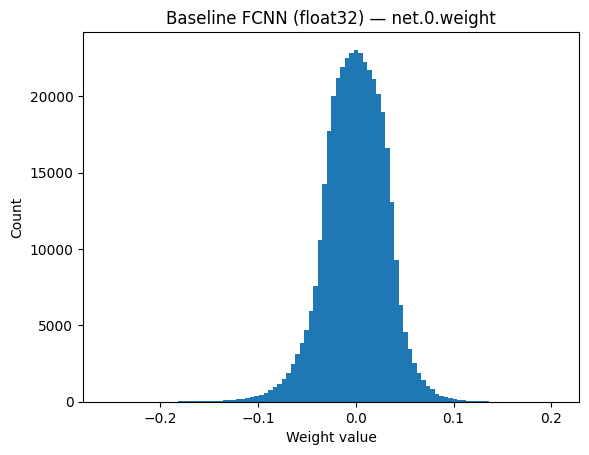

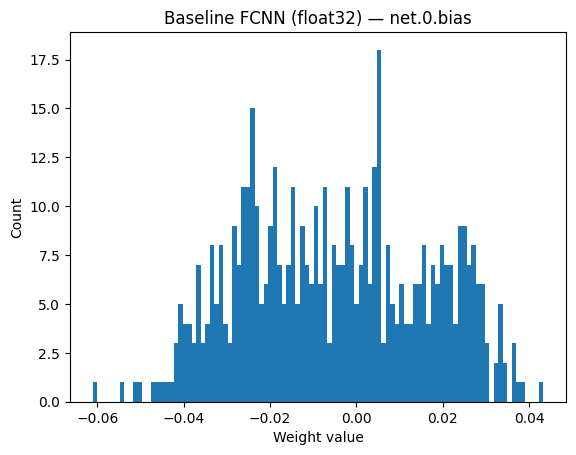

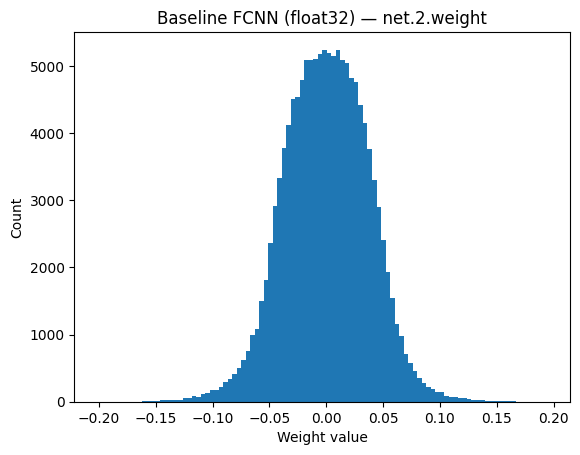

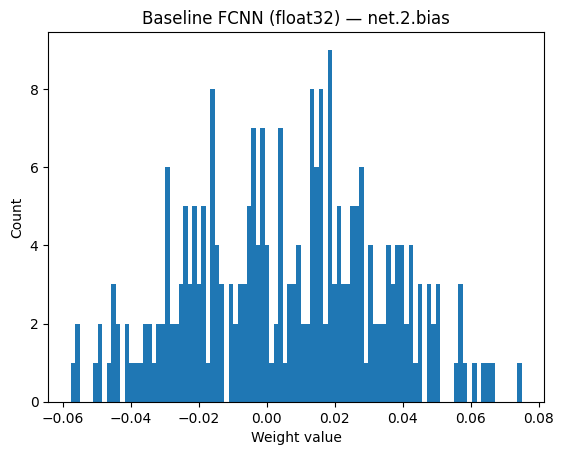

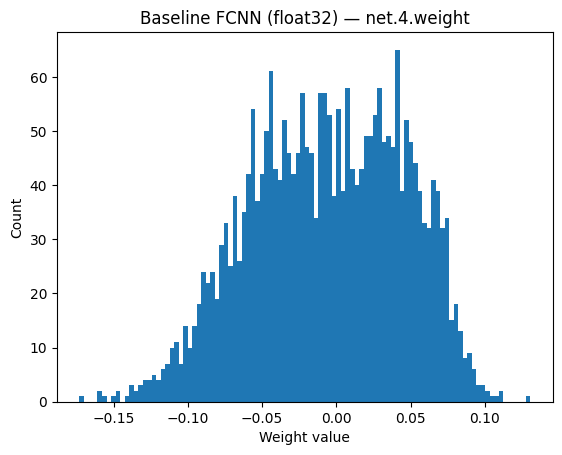

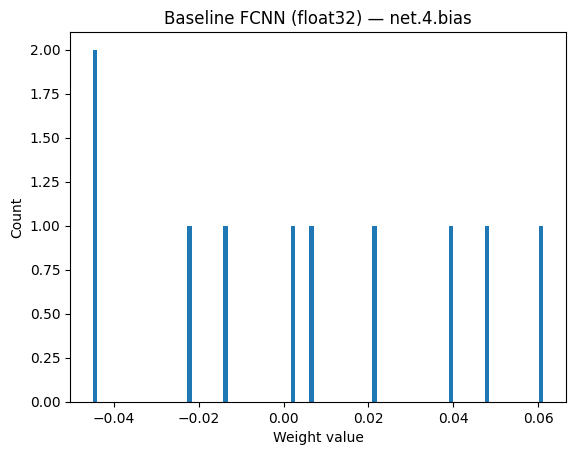

Plotting baseline CNN weights...


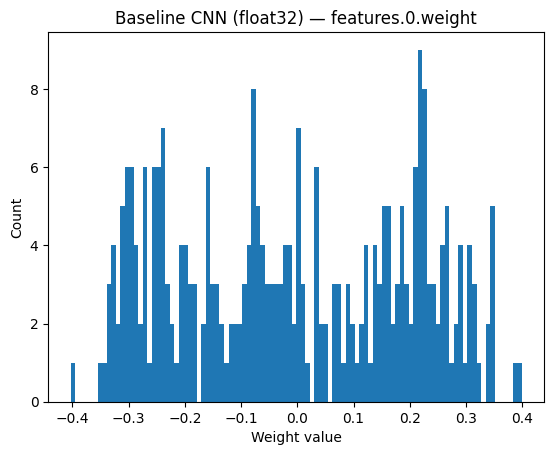

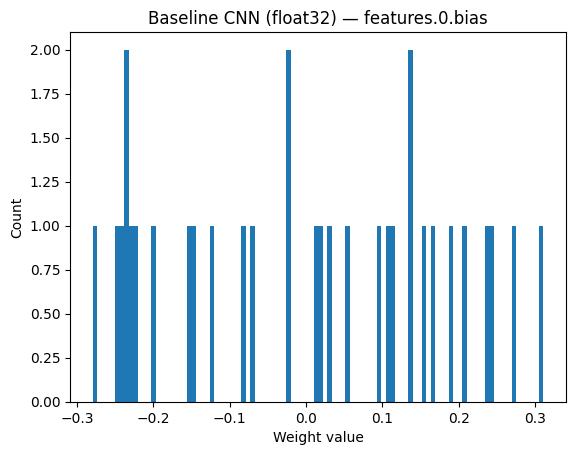

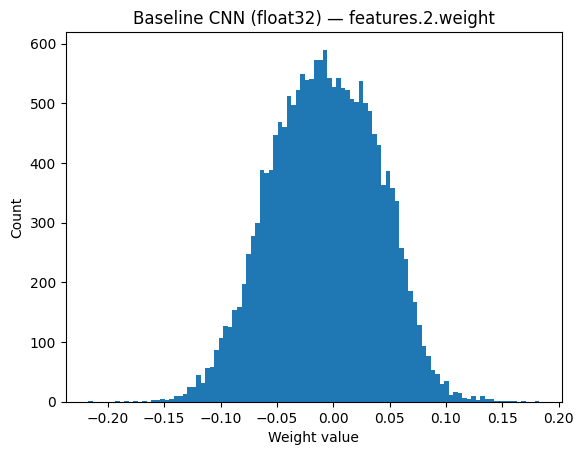

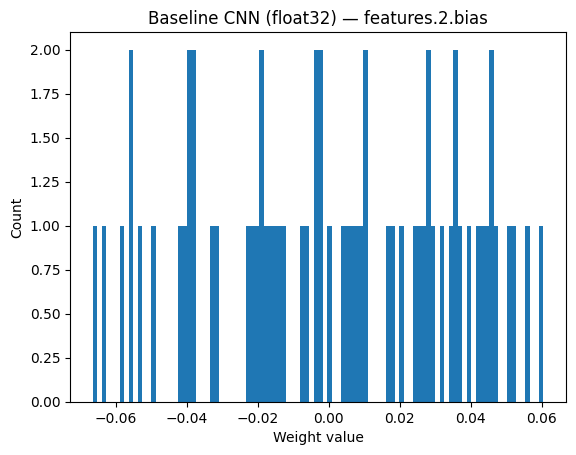

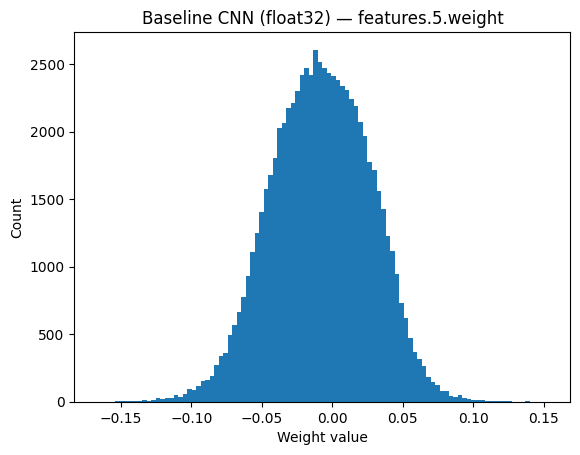

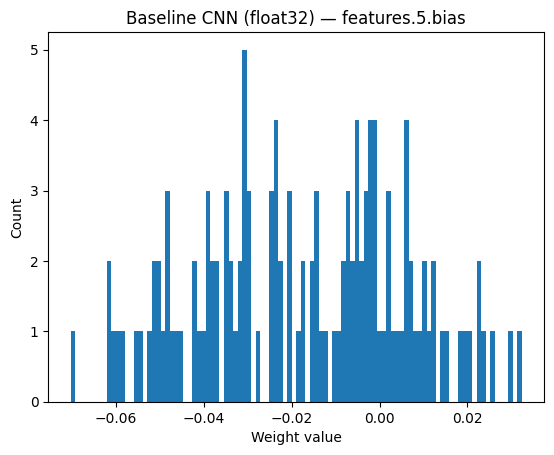

In [11]:
print("Plotting baseline FCNN weights...")
plot_weight_histograms(fcnn, "Baseline FCNN (float32)")

print("Plotting baseline CNN weights...")
plot_weight_histograms(cnn, "Baseline CNN (float32)")

## K-Means Weight Clustering (Post-Training)

KMeans(16) -> FCNN: 97.20% | CNN: 99.15%
Plotting KMeans-quantized FCNN weights...


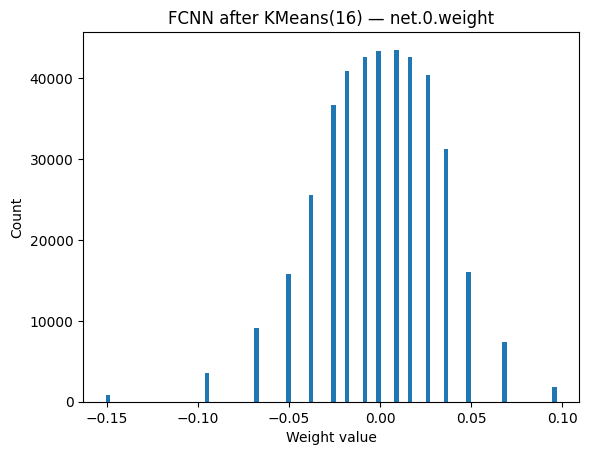

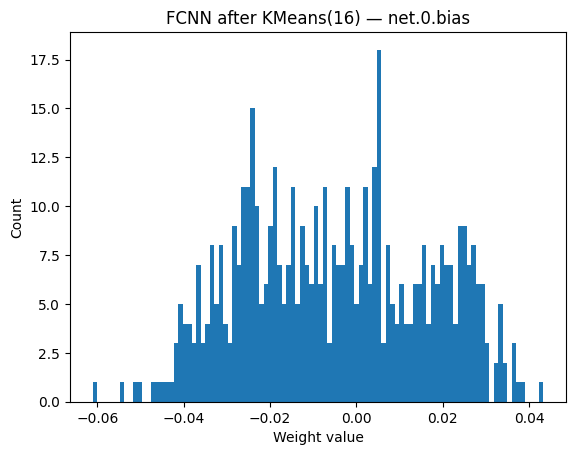

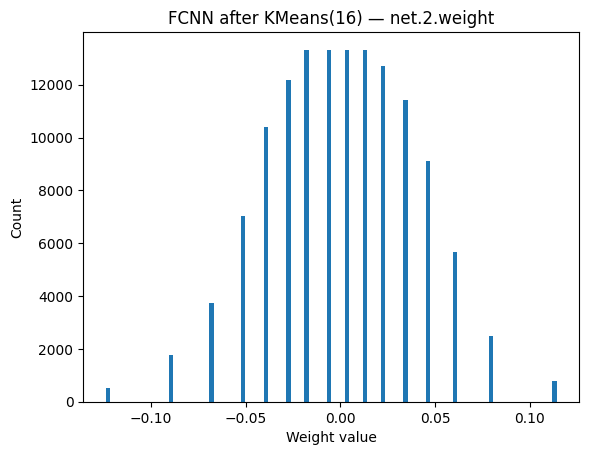

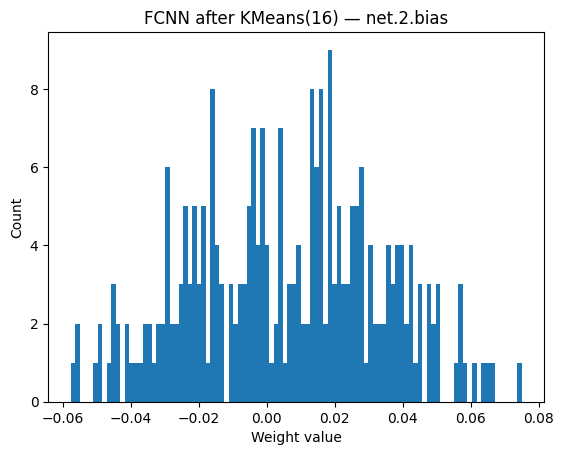

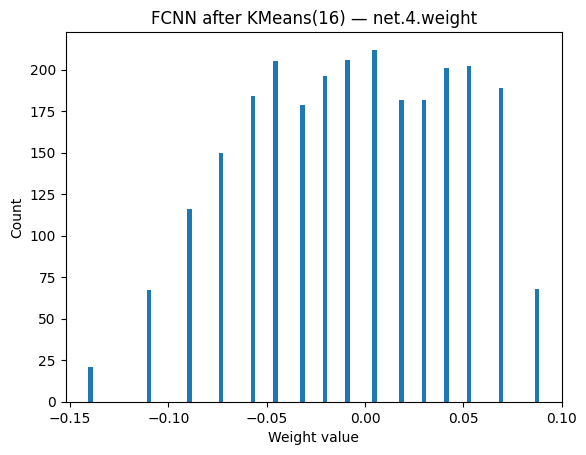

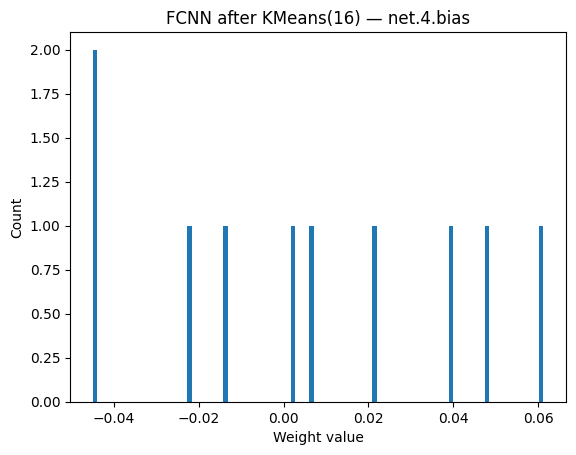

Plotting KMeans-quantized CNN weights...


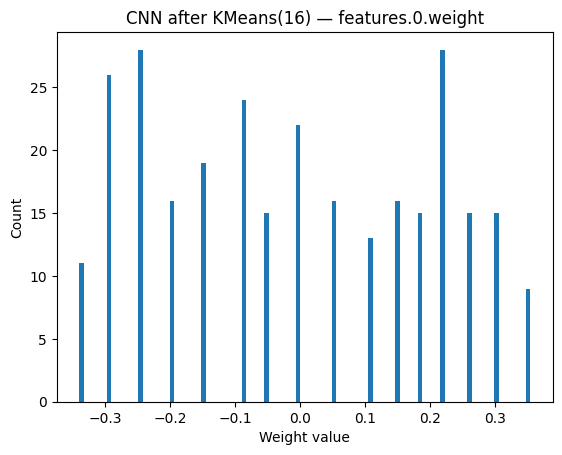

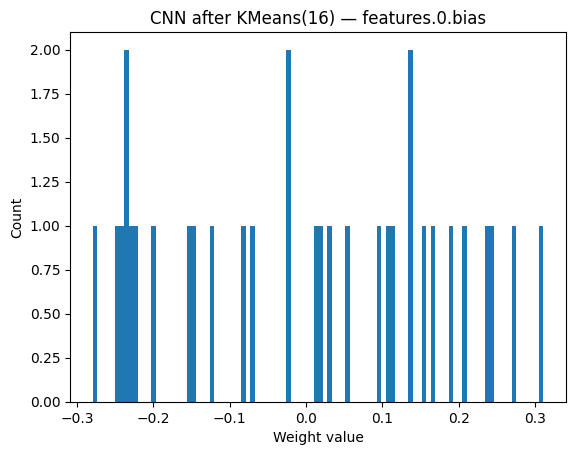

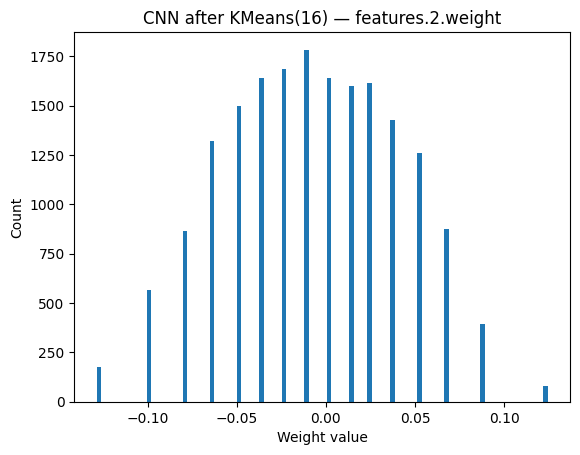

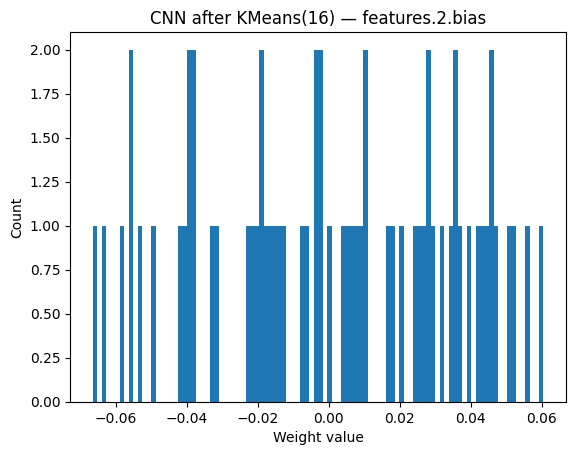

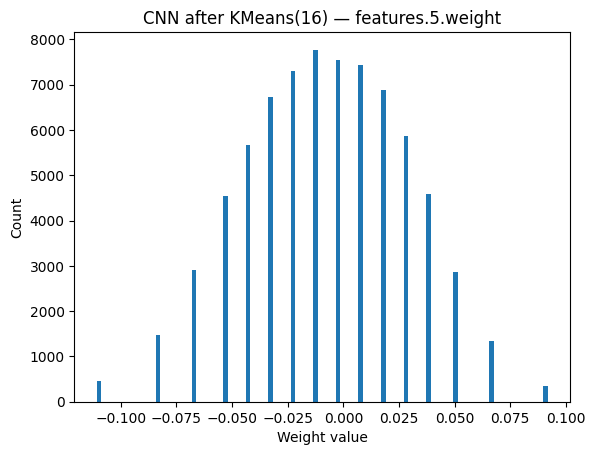

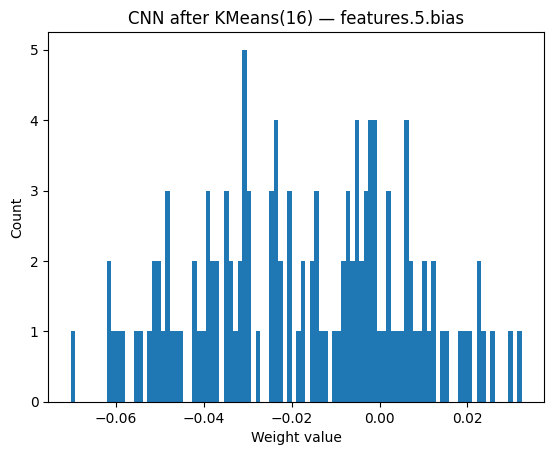

In [12]:
assert _SKLEARN_OK, "scikit-learn is required for KMeans quantization"

def kmeans_quantize_tensor(w: torch.Tensor, n_clusters: int = 16) -> torch.Tensor:
    shape = w.shape
    x = w.detach().view(-1, 1).cpu().numpy().astype(np.float32)
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=SEED)
    km.fit(x)
    centers = km.cluster_centers_.reshape(-1)
    labels = km.labels_
    q = centers[labels].reshape(-1, 1)
    q = torch.from_numpy(q.reshape(-1)).view(*shape).to(w.device).type_as(w)
    return q

def kmeans_quantize_model(model: nn.Module, n_clusters: int = 16, include_bias: bool = False) -> nn.Module:
    qm = copy.deepcopy(model).to(device)
    with torch.no_grad():
        for name, p in qm.named_parameters():
            if not p.requires_grad:
                continue
            if (not include_bias) and ("bias" in name):
                continue
            if p.dim() == 0:
                continue
            p.copy_(kmeans_quantize_tensor(p, n_clusters=n_clusters))
    return qm

fcnn_km = kmeans_quantize_model(fcnn, n_clusters=16, include_bias=False)
cnn_km  = kmeans_quantize_model(cnn,  n_clusters=16, include_bias=False)

acc_fcnn_km = evaluate(fcnn_km, test_loader)
acc_cnn_km  = evaluate(cnn_km,  test_loader)

print(f"KMeans(16) -> FCNN: {acc_fcnn_km:.2f}% | CNN: {acc_cnn_km:.2f}%")

print("Plotting KMeans-quantized FCNN weights...")
plot_weight_histograms(fcnn_km, "FCNN after KMeans(16)")

print("Plotting KMeans-quantized CNN weights...")
plot_weight_histograms(cnn_km, "CNN after KMeans(16)")

## Linear (Uniform) Quantization (Post-Training, Per-Tensor)

Linear-8bit -> FCNN: 97.22% | CNN: 99.23%
Plotting Linear-quantized FCNN weights...


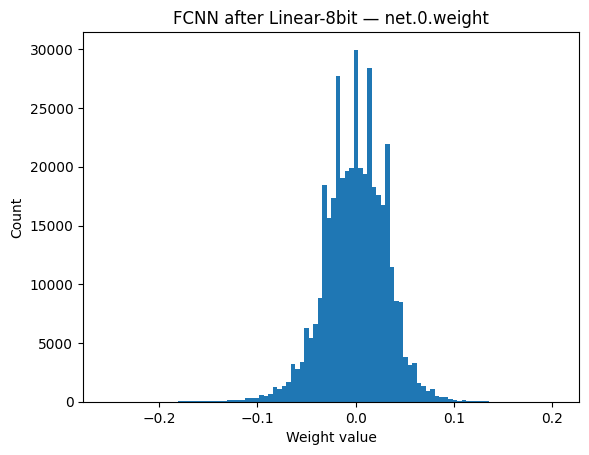

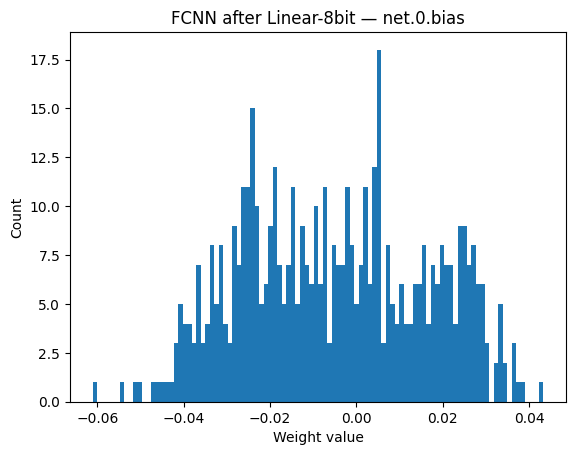

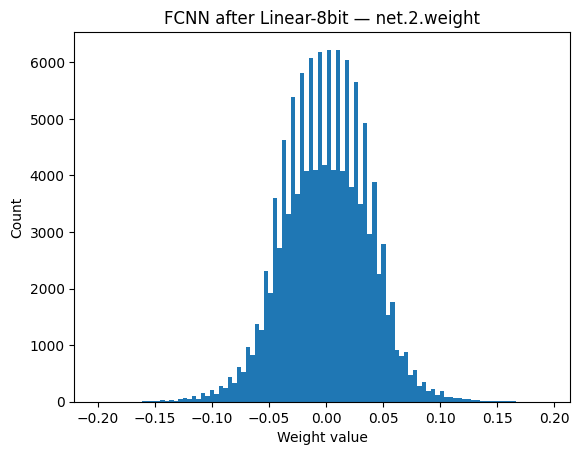

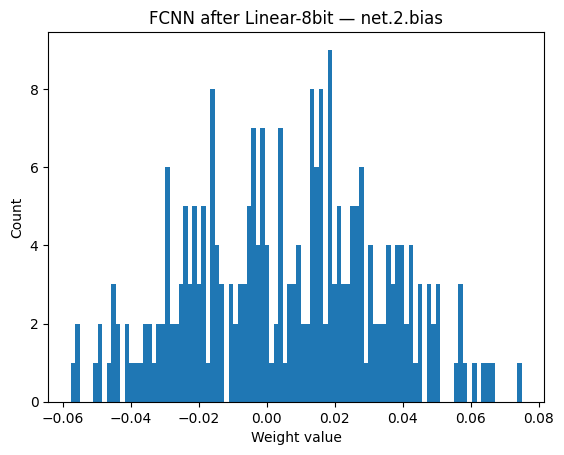

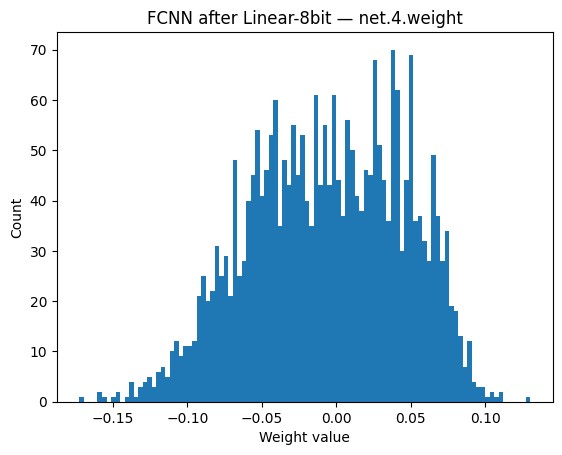

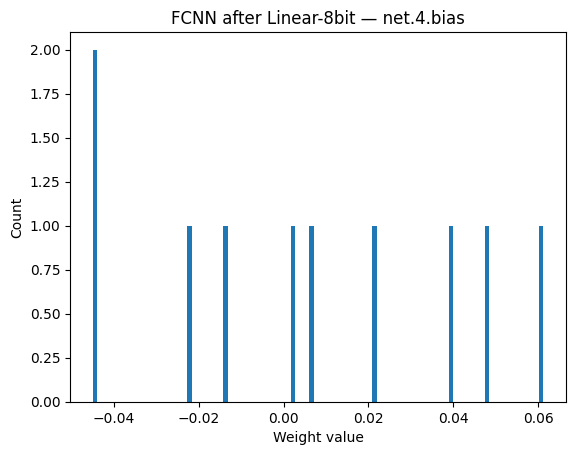

Plotting Linear-quantized CNN weights...


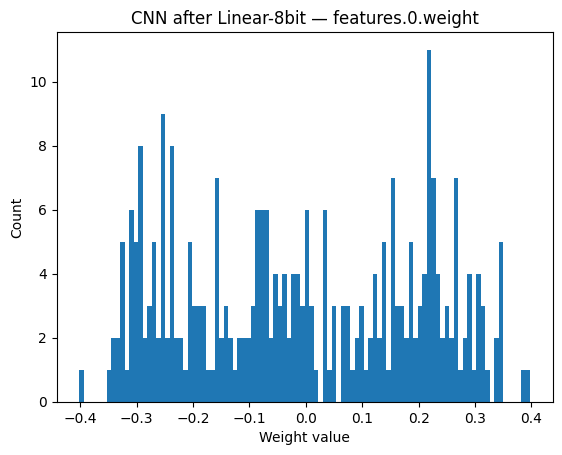

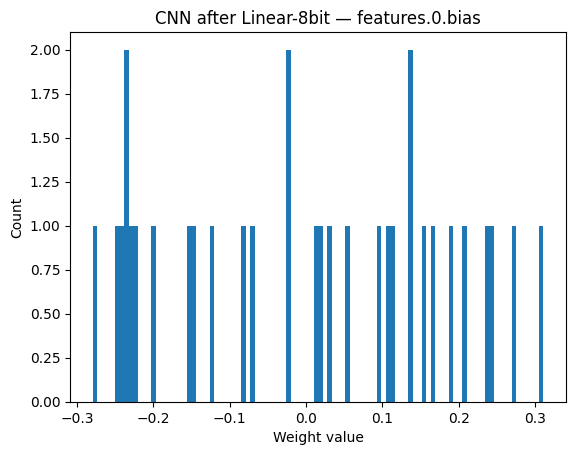

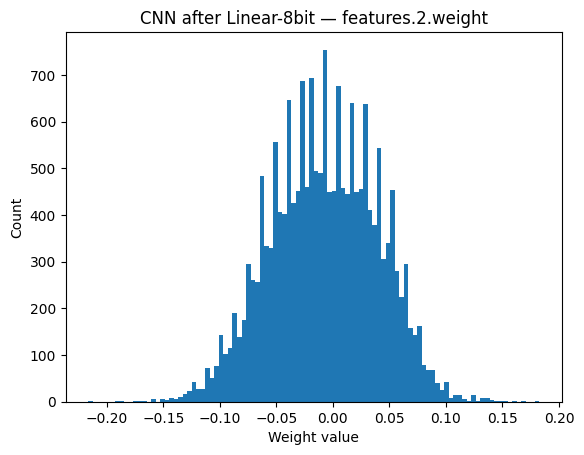

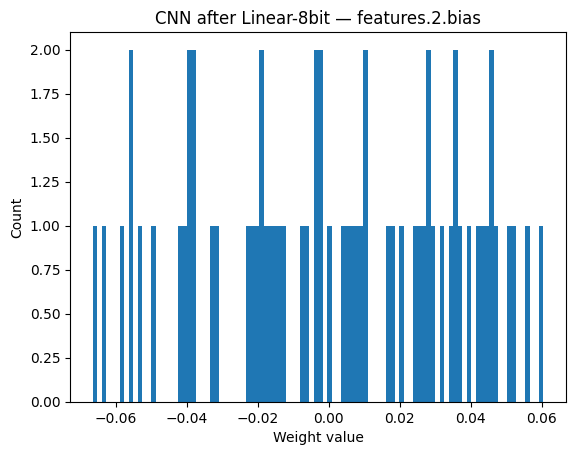

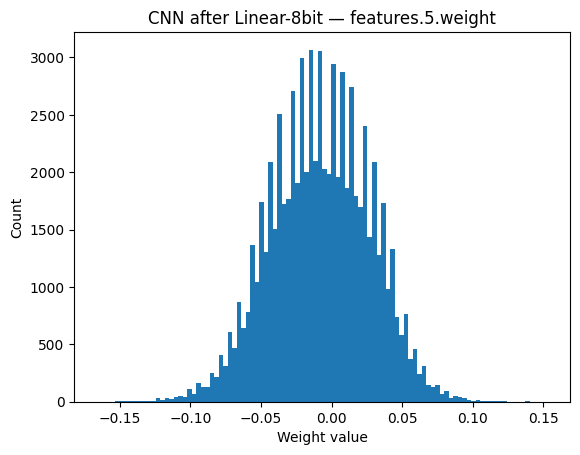

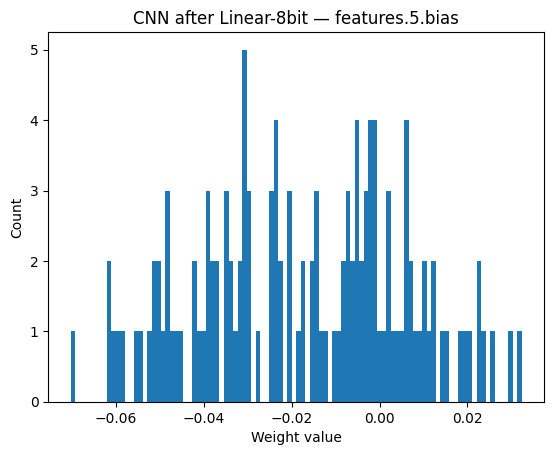

In [13]:
def linear_quantize_tensor(w: torch.Tensor, num_bits: int = 8, symmetric: bool = True):
    x = w.detach()
    qmin, qmax = 0, (2**num_bits - 1)

    if symmetric:
        max_abs = x.abs().max()
        scale = max_abs / ((qmax - qmin) / 2) if max_abs > 0 else torch.tensor(1.0, device=x.device)
        zp = (qmin + qmax) // 2
    else:
        xmin, xmax = x.min(), x.max()
        if (xmax - xmin) < 1e-12:
            scale = torch.tensor(1.0, device=x.device)
            zp = 0
        else:
            scale = (xmax - xmin) / (qmax - qmin)
            zp = int(qmin - torch.round(xmin / scale).item())

    q = torch.clamp(torch.round(x / scale + zp), qmin, qmax)
    x_hat = (q - zp) * scale
    return x_hat.to(w.device).type_as(w), float(scale.item()), int(zp)

def linear_quantize_model(model: nn.Module, num_bits: int = 8, symmetric: bool = True, include_bias: bool = False) -> nn.Module:
    qm = copy.deepcopy(model).to(device)
    with torch.no_grad():
        for name, p in qm.named_parameters():
            if not p.requires_grad:
                continue
            if (not include_bias) and ("bias" in name):
                continue
            if p.dim() == 0:
                continue
            xhat, scale, zp = linear_quantize_tensor(p, num_bits=num_bits, symmetric=symmetric)
            p.copy_(xhat)
    return qm

fcnn_lq = linear_quantize_model(fcnn, num_bits=8, symmetric=True, include_bias=False)
cnn_lq  = linear_quantize_model(cnn,  num_bits=8, symmetric=True, include_bias=False)

acc_fcnn_lq = evaluate(fcnn_lq, test_loader)
acc_cnn_lq  = evaluate(cnn_lq,  test_loader)

print(f"Linear-8bit -> FCNN: {acc_fcnn_lq:.2f}% | CNN: {acc_cnn_lq:.2f}%")

print("Plotting Linear-quantized FCNN weights...")
plot_weight_histograms(fcnn_lq, "FCNN after Linear-8bit")

print("Plotting Linear-quantized CNN weights...")
plot_weight_histograms(cnn_lq, "CNN after Linear-8bit")

## Quantization-Aware Training (QAT)

In [14]:
from torch.ao.quantization import QuantStub, DeQuantStub, prepare_qat, convert, get_default_qat_qconfig, FakeQuantize
from torch.ao.quantization.observer import MovingAverageMinMaxObserver, MovingAveragePerChannelMinMaxObserver

class FCNN_QAT(nn.Module):
    def __init__(self, in_dim=28*28, hidden=(512, 256), num_classes=10):
        super().__init__()
        self.quant, self.dequant = QuantStub(), DeQuantStub()
        layers, last = [], in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU(inplace=True)]
            last = h
        layers += [nn.Linear(last, num_classes)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.quant(x)
        x = self.net(x)
        x = self.dequant(x)
        return x

class SimpleCNN_QAT(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.quant, self.dequant = QuantStub(), DeQuantStub()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7,256), nn.ReLU(inplace=True),
            nn.Linear(256,10),
        )
    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = self.classifier(x)
        x = self.dequant(x)
        return x

def fuse_fcnn_qat(m: FCNN_QAT):
    from torch.ao.quantization.fuse_modules import fuse_modules
    pairs = []
    for i in range(len(m.net)-1):
        if isinstance(m.net[i], nn.Linear) and isinstance(m.net[i+1], nn.ReLU):
            pairs.append([f"net.{i}", f"net.{i+1}"])
    if pairs: fuse_modules(m, pairs, inplace=True)

def fuse_cnn_qat(m: SimpleCNN_QAT):
    from torch.ao.quantization.fuse_modules import fuse_modules
    for p in [["features.0","features.1"],
              ["features.2","features.3"],
              ["features.5","features.6"],
              ["classifier.1","classifier.2"]]:
        try: fuse_modules(m, p, inplace=True)
        except: pass

def make_qconfig_bits(bits: int):
    assert 2 <= bits <= 8
    a_qmin, a_qmax = 0, (1<<bits)-1
    w_qmin, w_qmax = -(1<<(bits-1))+1, (1<<(bits-1))-1
    act_fake = FakeQuantize.with_args(observer=MovingAverageMinMaxObserver,
                                      dtype=torch.quint8, qscheme=torch.per_tensor_affine,
                                      quant_min=a_qmin, quant_max=a_qmax)
    wt_fake  = FakeQuantize.with_args(observer=MovingAveragePerChannelMinMaxObserver,
                                      dtype=torch.qint8, qscheme=torch.per_channel_symmetric, ch_axis=0,
                                      quant_min=w_qmin, quant_max=w_qmax)
    from torch.ao.quantization.qconfig import QConfig
    return QConfig(activation=act_fake, weight=wt_fake)


Quant backend: x86 | qconfig backend: fbgemm
[FCNN] baseline FP32: 97.23%

[FCNN] QAT @ 8-bit …


/tmp/ipython-input-2675929550.py:55: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepare_qat(m, inplace=True)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.war

[FCNN] 8-bit: 98.17% (before 97.23%) Δ=+0.94 [int8]

[FCNN] QAT @ 6-bit …
[FCNN] 6-bit: 98.01% (before 97.23%) Δ=+0.78 [qat-fake-quant(float)]

[FCNN] QAT @ 4-bit …
[FCNN] 4-bit: 97.48% (before 97.23%) Δ=+0.25 [qat-fake-quant(float)]


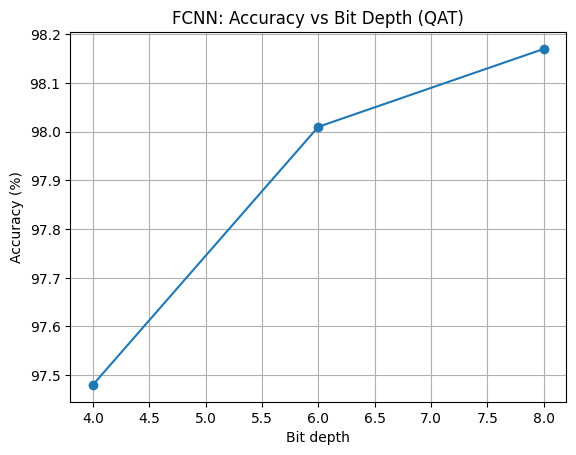

[SimpleCNN] baseline FP32: 99.22%

[SimpleCNN] QAT @ 8-bit …
[SimpleCNN] 8-bit: 99.28% (before 99.22%) Δ=+0.06 [int8]

[SimpleCNN] QAT @ 6-bit …
[SimpleCNN] 6-bit: 99.32% (before 99.22%) Δ=+0.10 [qat-fake-quant(float)]

[SimpleCNN] QAT @ 4-bit …
[SimpleCNN] 4-bit: 99.06% (before 99.22%) Δ=-0.16 [qat-fake-quant(float)]


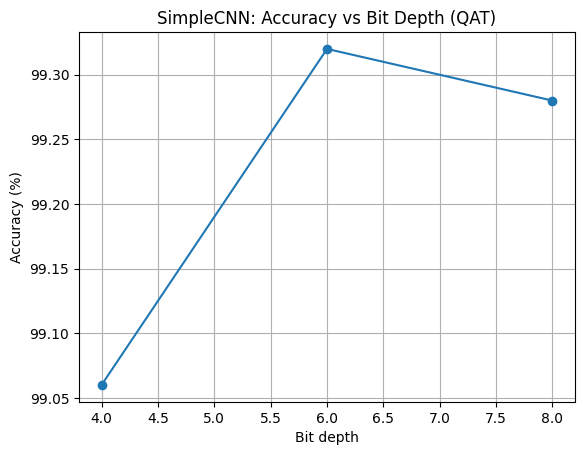

In [15]:

engines = getattr(torch.backends.quantized, "supported_engines", [])
backend = "x86" if "x86" in engines else ("fbgemm" if "fbgemm" in engines else "qnnpack")
torch.backends.quantized.engine = backend
qconfig_backend = "fbgemm" if backend in ("x86", "fbgemm") else "qnnpack"
print("Quant backend:", backend, "| qconfig backend:", qconfig_backend)

BIT_DEPTHS = [8, 6, 4]

# Training Loop
def train_qat(model, epochs=1, lr=1e-4):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for i, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to("cpu"), yb.to("cpu")
            opt.zero_grad(set_to_none=True)
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
            if i >= 200:
                break

# Evaluation Function
@torch.no_grad()
def eval_cpu(m):
    m.eval()
    correct, tot = 0, 0
    for xb, yb in test_loader:
        xb, yb = xb.to("cpu"), yb.to("cpu")
        pred = m(xb).argmax(1)
        correct += (pred == yb).sum().item()
        tot += yb.size(0)
    return 100.0 * correct / tot

def run_qat_bits(model_ctor, float_model, fuse_fn, label):
    if float_model is None:
        raise RuntimeError(f"{label}: baseline float model is None. Define/train it before QAT.")
    base = eval_cpu(float_model.to("cpu").eval())
    print(f"[{label}] baseline FP32: {base:.2f}%")

    results, converted = [], {}

    for b in BIT_DEPTHS:
        print(f"\n[{label}] QAT @ {b}-bit …")
        m = model_ctor().to("cpu")
        m.load_state_dict(float_model.state_dict(), strict=False)
        fuse_fn(m)
        if b == 8:
            qcfg = get_default_qat_qconfig(qconfig_backend)
        else:
            qcfg = make_qconfig_bits(b)
        m.qconfig = qcfg
        m.train()
        prepare_qat(m, inplace=True)

        train_qat(m, epochs=1, lr=1e-4)

        if b == 8:
            m.eval()
            q8 = convert(m, inplace=False)
            try:
                acc, mode = eval_cpu(q8), "int8"
                converted[b] = q8
            except Exception as e:
                if "quantized::" in str(e):
                    acc, mode = eval_cpu(m), "qat-fake-quant(float)"
                else:
                    raise
        else:
            m.eval()
            acc, mode = eval_cpu(m), "qat-fake-quant(float)"

        print(f"[{label}] {b}-bit: {acc:.2f}% (before {base:.2f}%) Δ={acc-base:+.2f} [{mode}]")
        results.append((b, acc, base, mode))

    # Accuracy vs bit depth plot
    bits = [b for b,_,_,_ in results]
    accs = [a for _,a,_,_ in results]
    plt.figure(); plt.plot(bits, accs, marker="o"); plt.grid(True)
    plt.title(f"{label}: Accuracy vs Bit Depth (QAT)")
    plt.xlabel("Bit depth"); plt.ylabel("Accuracy (%)")
    plt.show()
    return base, results, converted

fcnn_base, fcnn_res, fcnn_int8m = run_qat_bits(
    lambda: FCNN_QAT(28*28, (512, 256), 10), fcnn, fuse_fcnn_qat, "FCNN"
)
cnn_base,  cnn_res,  cnn_int8m  = run_qat_bits(
    lambda: SimpleCNN_QAT(10),              cnn,  fuse_cnn_qat,  "SimpleCNN"
)


## Helper functions to visualize before and after comaprison

In [36]:
import os, tempfile, torch, pandas as pd
from collections import OrderedDict
from torch.ao.quantization import get_default_qat_qconfig, prepare_qat, convert

engines = getattr(torch.backends.quantized, "supported_engines", [])
backend = "x86" if "x86" in engines else ("fbgemm" if "fbgemm" in engines else "qnnpack")
torch.backends.quantized.engine = backend
qconfig_backend = "fbgemm" if backend in ("x86", "fbgemm") else "qnnpack"
print("Quant backend:", backend, "| qconfig backend:", qconfig_backend)

def save_state_size_mb(model: torch.nn.Module) -> float:
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pt") as f:
        tmp = f.name
    try:
        torch.save(model.state_dict(), tmp)
        return os.path.getsize(tmp) / (1024**2)
    finally:
        try: os.remove(tmp)
        except: pass

@torch.no_grad()
def eval_acc(model: torch.nn.Module, loader) -> float:
    model.eval(); model.to("cpu")
    tot = correct = 0
    for xb, yb in loader:
        xb, yb = xb.to("cpu"), yb.to("cpu")
        pred = model(xb).argmax(1)
        correct += (pred == yb).sum().item()
        tot += yb.size(0)
    return 100.0 * correct / tot

def qat_int8_strict(float_model, model_ctor_qat, fuse_fn, backend_name="fbgemm", steps=200, lr=1e-4):
    """
    Prepare QAT -> brief finetune -> CONVERT to INT8.
    """
    m = model_ctor_qat().to("cpu")
    m.load_state_dict(float_model.state_dict(), strict=False)
    fuse_fn(m)

    # QAT config
    m.qconfig = get_default_qat_qconfig(backend_name)
    m.train(); prepare_qat(m, inplace=True)

    # finetune
    opt = torch.optim.Adam(m.parameters(), lr=lr)
    crit = torch.nn.CrossEntropyLoss()
    seen = 0
    for xb, yb in train_loader:
        xb, yb = xb.to("cpu"), yb.to("cpu")
        opt.zero_grad(set_to_none=True)
        loss = crit(m(xb), yb)
        loss.backward(); opt.step()
        seen += xb.size(0)
        if seen >= steps: break

    m.eval()
    q8 = convert(m, inplace=False)
    any_quant = False
    for name, mod in q8.named_modules():
        if hasattr(mod, "weight"):
            w = mod.weight() if callable(getattr(mod, "weight", None)) else getattr(mod, "weight", None)
            if hasattr(w, "is_quantized") and w.is_quantized:
                any_quant = True
                break
    return q8

def build_before_after_table_convert_only(fcnn_float, cnn_float) -> pd.DataFrame:
    rows = []

    # Baselines
    fcnn_b_acc = eval_acc(fcnn_float, test_loader)
    fcnn_b_sz  = save_state_size_mb(fcnn_float)
    cnn_b_acc  = eval_acc(cnn_float, test_loader)
    cnn_b_sz   = save_state_size_mb(cnn_float)

    # FCNN -> QAT INT8
    fcnn_q8 = qat_int8_strict(
        fcnn_float, lambda: FCNN_QAT(28*28,(512,256),10), fuse_fcnn_qat, backend_name=qconfig_backend,
        steps=200, lr=1e-4
    )
    rows.append(OrderedDict(
        model="FCNN", method="QAT INT8 (converted)",
        acc_before=round(fcnn_b_acc,2), acc_after=round(eval_acc(fcnn_q8, test_loader),2),
        size_before_mb=round(fcnn_b_sz,3), size_after_mb=round(save_state_size_mb(fcnn_q8),3)
    ))

    # CNN -> QAT INT8
    cnn_q8 = qat_int8_strict(
        cnn_float, lambda: SimpleCNN_QAT(10), fuse_cnn_qat, backend_name=qconfig_backend,
        steps=200, lr=1e-4
    )
    rows.append(OrderedDict(
        model="CNN", method="QAT INT8 (converted)",
        acc_before=round(cnn_b_acc,2), acc_after=round(eval_acc(cnn_q8, test_loader),2),
        size_before_mb=round(cnn_b_sz,3), size_after_mb=round(save_state_size_mb(cnn_q8),3)
    ))

    return pd.DataFrame(rows, columns=[
        "model","method","acc_before","acc_after","size_before_mb","size_after_mb"
    ])

# build and then show before and after results
df = build_before_after_table_convert_only(fcnn, cnn)
print(df.to_string(index=False))


Quant backend: x86 | qconfig backend: fbgemm


/tmp/ipython-input-2689933519.py:42: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  m.train(); prepare_qat(m, inplace=True)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  w

model               method  acc_before  acc_after  size_before_mb  size_after_mb
 FCNN QAT INT8 (converted)       97.23      97.32           2.047          0.532
  CNN QAT INT8 (converted)       99.22      99.17           6.494          1.641
